<a href="https://colab.research.google.com/github/sasha-kap/Events-Analytics/blob/master/GDELT_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Provide credentials to the runtime

In [4]:
# authenticates Colab to the Google Cloud account
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### BigQuery dry run

In [0]:
from google.cloud import bigquery

Dry run query to check query size across different date ranges:

In [5]:
project_id = 'spark-project-254623'

client = bigquery.Client(project=project_id)

job_config = bigquery.QueryJobConfig()
job_config.dry_run = True
job_config.use_query_cache = False

sql =   '''
        SELECT *
        FROM `gdelt-bq.gdeltv2.events_partitioned`
        WHERE
            _PARTITIONDATE BETWEEN '2018-04-04' AND '2018-04-04'
        '''

query_job = client.query(
    sql,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config,
)  # API request

# A dry run query completes immediately.
assert query_job.state == "DONE"
assert query_job.dry_run

print("This query will process {:,} bytes.".format(query_job.total_bytes_processed))

This query will process 144,510,139 bytes.


### Query Events Table

In [0]:
import pandas as pd

In [0]:
project_id = 'spark-project-254623'

client = bigquery.Client(project=project_id)

sql =   '''
        SELECT *
        FROM `gdelt-bq.gdeltv2.events_partitioned`
        WHERE
            _PARTITIONDATE BETWEEN '2019-12-01' AND '2019-12-07'
        '''

df = client.query(sql, location="US").to_dataframe()

### Save DataFrame to Pickle and then copy to existing Cloud Storage bucket

In [0]:
import pickle

In [0]:
df.to_pickle("./dec19_wk1_events.pkl")

In [0]:
bucket_name = 'spark-projects'

In [11]:
# upload file to GCS bucket
!gsutil cp ./dec19_wk1_events.pkl gs://{bucket_name}/dec19_wk1_events.pkl

Copying file://./dec19_wk1_events.pkl [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/689.8 MiB.                                    


### Copy Pickle file back to Colab instance

In [5]:
import pickle
bucket_name = 'spark-projects'

!gsutil cp gs://{bucket_name}/dec19_wk1_events.pkl ./dec19_wk1_events.pkl

df = pd.read_pickle("./dec19_wk1_events.pkl")

Copying gs://spark-projects/dec19_wk1_events.pkl...
/ [1 files][689.8 MiB/689.8 MiB]   71.8 MiB/s                                   
Operation completed over 1 objects/689.8 MiB.                                    


### Exploratory Analysis of Queried Events

#### Dataset Properties



In [6]:
print(df.shape)

(1496551, 61)


In [13]:
df.columns

Index(['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'FractionDate',
       'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode',
       'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code',
       'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code',
       'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code',
       'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent',
       'EventCode', 'EventBaseCode', 'EventRootCode', 'QuadClass',
       'GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone',
       'Actor1Geo_Type', 'Actor1Geo_FullName', 'Actor1Geo_CountryCode',
       'Actor1Geo_ADM1Code', 'Actor1Geo_ADM2Code', 'Actor1Geo_Lat',
       'Actor1Geo_Long', 'Actor1Geo_FeatureID', 'Actor2Geo_Type',
       'Actor2Geo_FullName', 'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code',
       'Actor2Geo_ADM2Code', 'Actor2Geo_Lat', 'Act

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496551 entries, 0 to 1496550
Data columns (total 61 columns):
GLOBALEVENTID            1496551 non-null int64
SQLDATE                  1496551 non-null int64
MonthYear                1496551 non-null int64
Year                     1496551 non-null int64
FractionDate             1496551 non-null float64
Actor1Code               1341035 non-null object
Actor1Name               1341038 non-null object
Actor1CountryCode        783423 non-null object
Actor1KnownGroupCode     23614 non-null object
Actor1EthnicCode         8737 non-null object
Actor1Religion1Code      18476 non-null object
Actor1Religion2Code      5172 non-null object
Actor1Type1Code          686425 non-null object
Actor1Type2Code          39625 non-null object
Actor1Type3Code          1052 non-null object
Actor2Code               1032836 non-null object
Actor2Name               1032836 non-null object
Actor2CountryCode        619282 non-null object
Actor2KnownGroupCode     2

#### Actor and Event Codes

In [36]:
df[df.Actor1Code.isnull()].shape

(155516, 61)

In [26]:
# tabulate number of unique EventCode's in cases where Actor1Code is null
df[df.Actor1Code.isnull()]['EventCode'].unique().shape

(200,)

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [25]:
print(mpl.__version__)

3.1.2


In [0]:
plt.style.use('seaborn')

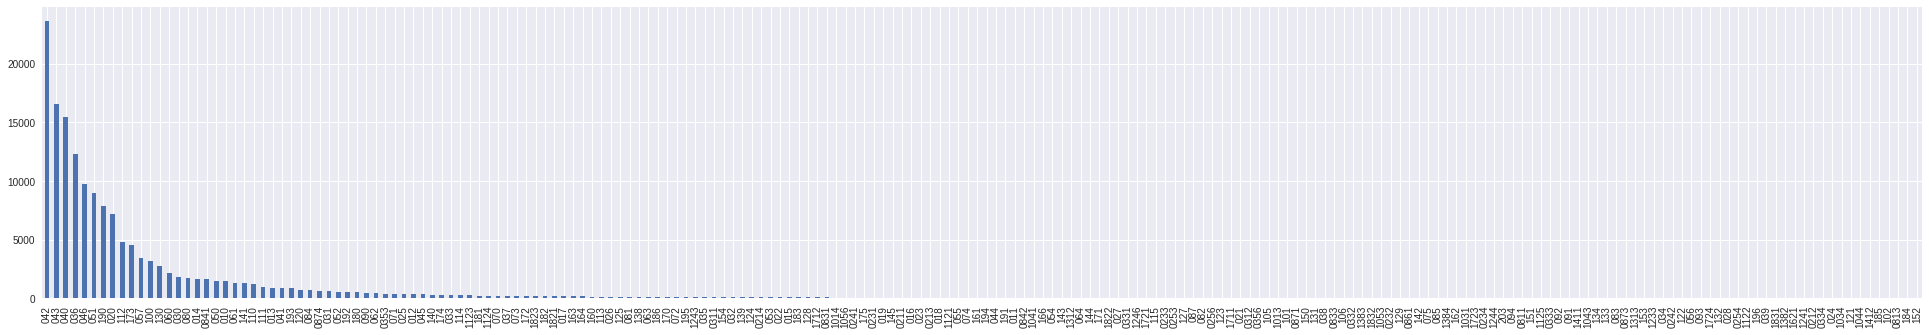

In [34]:
# plot frequencies of EventCode values for events when Actor1Code is null
plt.figure(figsize=(30,5))
df[df.Actor1Code.isnull()]['EventCode'].value_counts().plot(kind="bar")
plt.show()

In [39]:
event_code_cts = df[df.Actor1Code.isnull()]['EventCode'].value_counts()
event_code_cts[event_code_cts > 100]

042     23679
043     16537
040     15494
036     12304
046      9746
        ...  
1243      119
035       117
0311      108
154       106
032       104
Name: EventCode, Length: 74, dtype: int64

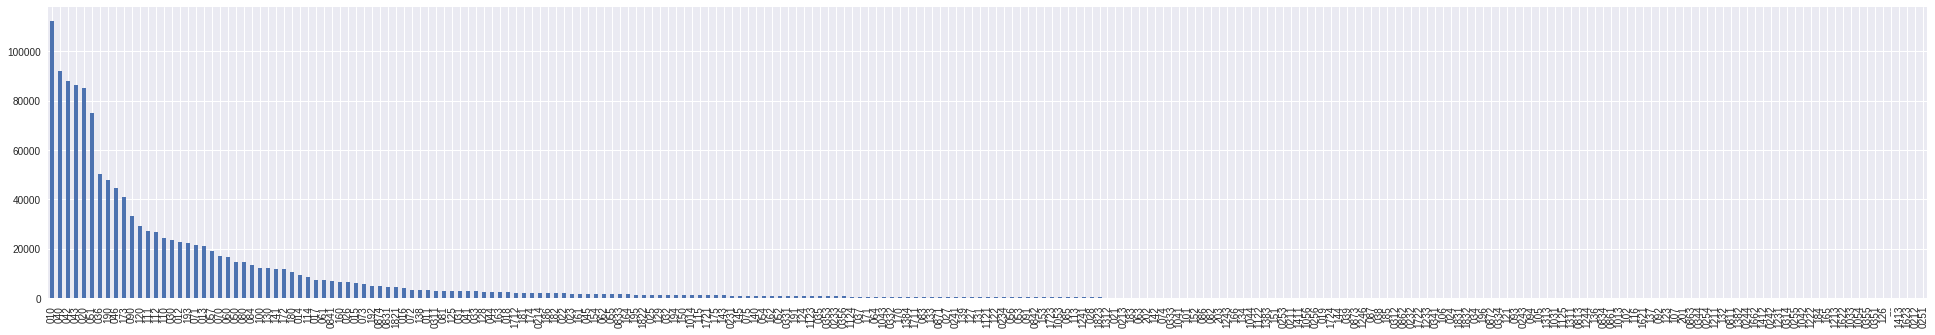

In [40]:
# plot frequencies of EventCode values for events when Actor1Code is NOT null
plt.figure(figsize=(30,5))
df[df.Actor1Code.notnull()]['EventCode'].value_counts().plot(kind="bar")
plt.show()

In [49]:
# Check for overlaps between presence of Actor1Code and Actor2Code
print("Actor1Code NULL, Actor2Code NOT NULL:", df[df.Actor1Code.isnull() & df.Actor2Code.notnull()].shape[0], f"{df[df.Actor1Code.isnull() & df.Actor2Code.notnull()].shape[0] / df.shape[0] :.2%}")
print("Actor1Code NULL, Actor2Code NULL:", df[df.Actor1Code.isnull() & df.Actor2Code.isnull()].shape[0], f"{df[df.Actor1Code.isnull() & df.Actor2Code.isnull()].shape[0] / df.shape[0] :.2%}")
print("Actor1Code NOT NULL, Actor2Code NOT NULL:", df[df.Actor1Code.notnull() & df.Actor2Code.notnull()].shape[0], f"{df[df.Actor1Code.notnull() & df.Actor2Code.notnull()].shape[0] / df.shape[0] :.2%}")
print("Actor1Code NOT NULL, Actor2Code NULL:", df[df.Actor1Code.notnull() & df.Actor2Code.isnull()].shape[0], f"{df[df.Actor1Code.notnull() & df.Actor2Code.isnull()].shape[0] / df.shape[0] :.2%}")

Actor1Code NULL, Actor2Code NOT NULL: 155514 10.39%
Actor1Code NULL, Actor2Code NULL: 2 0.00%
Actor1Code NOT NULL, Actor2Code NOT NULL: 877322 58.62%
Actor1Code NOT NULL, Actor2Code NULL: 463713 30.99%


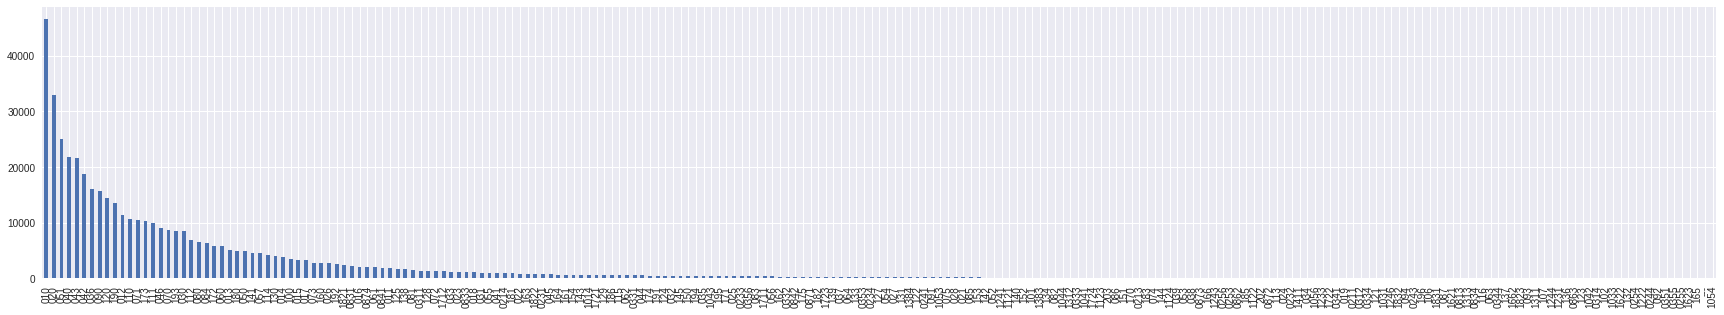

In [10]:
# plot frequencies of EventCode values for events when Actor1Code is NOT null and Actor2Code IS null
plt.figure(figsize=(30,5))
df[df.Actor1Code.notnull() & df.Actor2Code.isnull()]['EventCode'].value_counts().plot(kind="bar")
plt.show()

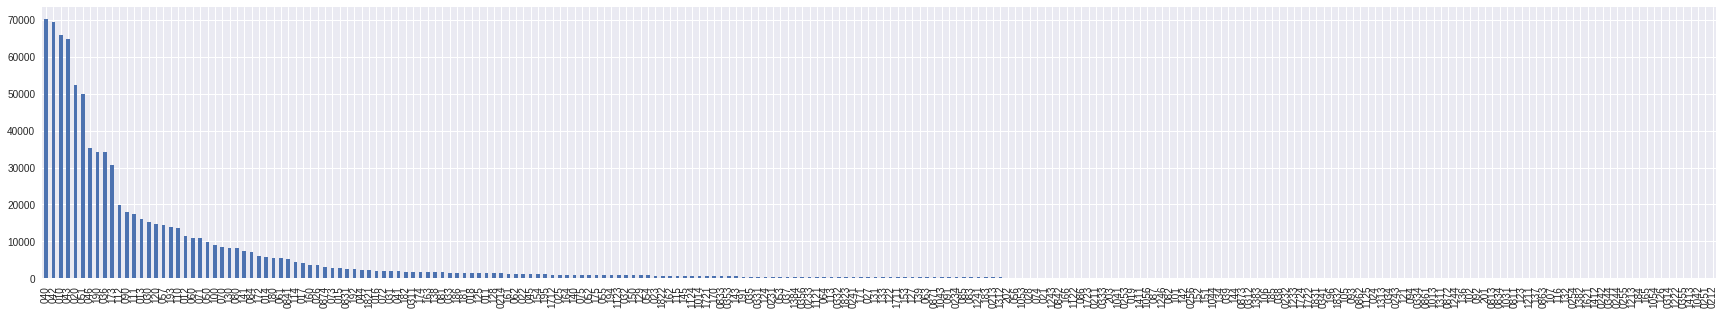

In [11]:
# plot frequencies of EventCode values for events when Actor1Code is NOT null and Actor2Code is NOT null
plt.figure(figsize=(30,5))
df[df.Actor1Code.notnull() & df.Actor2Code.notnull()]['EventCode'].value_counts().plot(kind="bar")
plt.show()

In [13]:
#check number of unique Actor1Code values
df[df.Actor1Code.notnull()].Actor1Code.value_counts().shape[0]

5158

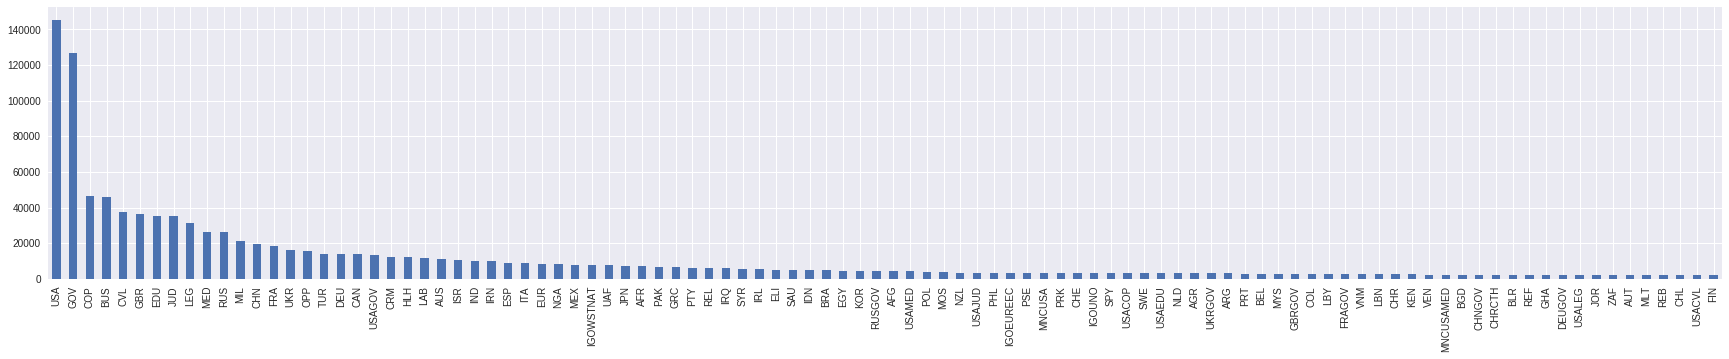

In [14]:
# plot frequencies of 100 most frequent Actor1Code values
plt.figure(figsize=(30,5))
df[df.Actor1Code.notnull()]['Actor1Code'].value_counts().nlargest(100).plot(kind="bar")
plt.show()

In [21]:
# Check the most frequent combinations of Actor1Code and Actor2Code
df.groupby([df.Actor1Code, df.Actor2Code]).size().nlargest(40)

Actor1Code  Actor2Code
USA         GOV           7849
GOV         USA           7732
USA         EDU           5721
            COP           5018
COP         USA           4694
USA         BUS           4569
EDU         USA           4468
USA         CVL           4466
JUD         USA           4114
USA         JUD           3757
LEG         GOV           3736
BUS         USA           3463
CVL         USA           3416
GOV         BUS           3284
            LEG           3283
USA         LEG           3183
USAGOV      USA           3150
USA         USAGOV        3054
GOV         CVL           2771
USA         MIL           2635
LEG         USA           2527
USA         MED           2436
BUS         GOV           2422
GOV         GBR           2414
RUS         UKR           2268
UKR         RUS           2234
GBR         GOV           2188
USA         UKR           2050
MIL         USA           2041
MED         USA           2028
USA         GBR           1964
GOV         EDU 

Many domestic group codes above (like LEG (Legislature) or MED (Media)) do not include a country code, so it is not clear which country's group is being referenced.

In [24]:
# Check which Actor1CountryCode values exist when Actor1Code just has one of the primary or secondary role codes
df[df.Actor1Code.isin(['GOV','COP','EDU','MIL','JUD','LEG','BUS','CVL','MED'])]['Actor1CountryCode'].value_counts()

Series([], Name: Actor1CountryCode, dtype: int64)

It does not look like Actor1CountryCode can assist in identifying the country of group in the Actor1Code column.  Let's check if Actor1Name can assist.

In [29]:
df[df.Actor1Code.isin(['GOV','COP','EDU','MIL','JUD','LEG','BUS','CVL','MED'])]['Actor1Name'].value_counts()

PRESIDENT                         29993
POLICE                            27258
GOVERNMENT                        24498
COMPANY                           12497
SCHOOL                            12002
                                  ...  
MINIST FOR ECONOMY AND FINANCE        1
SCHOOLS                               1
ATTACK HELICOPTER                     1
NON RESIDENTS                         1
AMBASSADOR FOR A                      1
Name: Actor1Name, Length: 780, dtype: int64

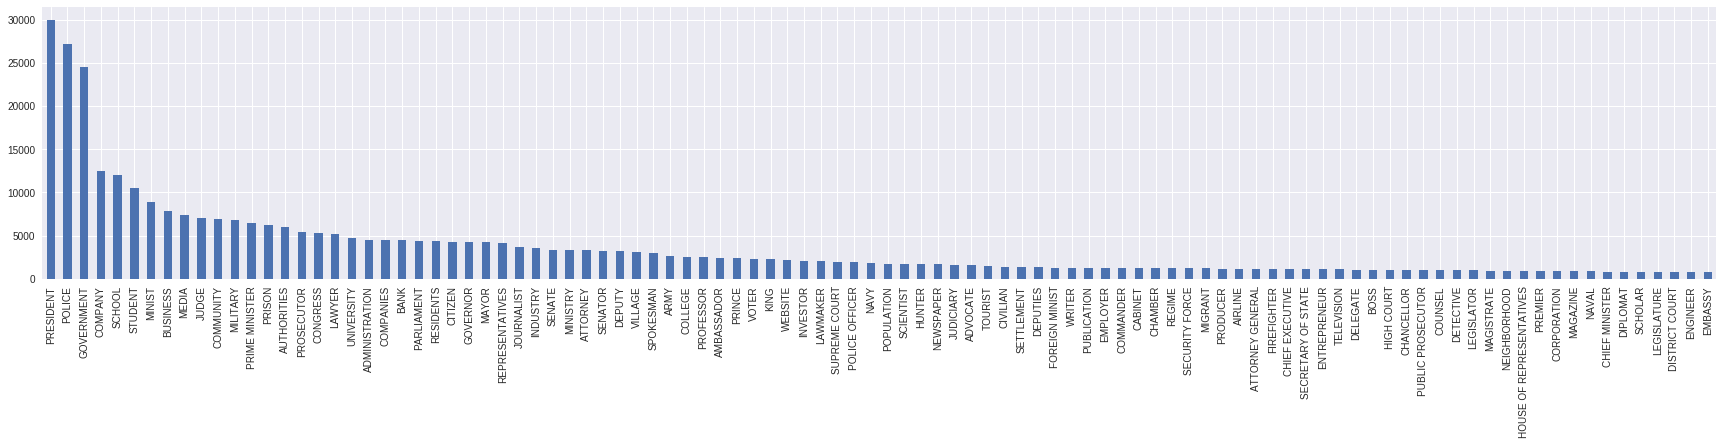

In [31]:
# plot frequencies of 100 most frequent Actor1Name values when Actor1Code has one of the main domestic group values
plt.figure(figsize=(30,5))
df[df.Actor1Code.isin(['GOV','COP','EDU','MIL','JUD','LEG','BUS','CVL','MED'])]['Actor1Name'].value_counts().nlargest(100).plot(kind="bar")
plt.show()

In [25]:
df.Actor1CountryCode.value_counts(dropna=False)

NaN    713128
USA    192390
GBR     43375
RUS     33352
CHN     23648
        ...  
SHN        13
CAS        11
LAM         6
SMR         6
SCN         4
Name: Actor1CountryCode, Length: 217, dtype: int64

In [26]:
df[df.Actor1CountryCode == "USA"]['Actor1Code'].value_counts(dropna=False)

USA             145273
USAGOV           13571
USAMED            4133
USAJUD            3524
MNCUSA            3421
                 ...  
USAEDUREF            1
MNCUSAHLHLEG         1
USAGUMMIL            1
USAGUMCVL            1
MNCUSAAGRBUS         1
Name: Actor1Code, Length: 141, dtype: int64

#### Actor Geo Type

In [50]:
# Check values of Actor1Geo_Type
df.Actor1Geo_Type.value_counts(dropna=False)

4    577831
1    405877
0    198945
3    165238
2    124355
5     24305
Name: Actor1Geo_Type, dtype: int64

In [32]:
# Check
df[df.Actor1Code.isin(['GOV','COP','EDU','MIL','JUD','LEG','BUS','CVL','MED'])]['Actor1Geo_Type'].value_counts()

4    169772
1    112544
3     52950
2     42601
0     18963
5      8703
Name: Actor1Geo_Type, dtype: int64

In [34]:
df[df.Actor1Code.isin(['GOV','COP','EDU','MIL','JUD','LEG','BUS','CVL','MED'])]['Actor1Geo_CountryCode'].value_counts()

US    103192
IN     22160
UK     17888
RS     14148
UP     10965
       ...  
TL         1
FK         1
PC         1
IM         1
NF         1
Name: Actor1Geo_CountryCode, Length: 241, dtype: int64